Obtaining Data and Query Preparation

For Milestone 2.1, one split of the MTG-Jamendo dataset corresponding to our group number 40 was downloaded and unpacked. This split contains approximately 550 music tracks, each provided as a 30-second audio excerpt, which were used as the music database.

From this database, 20 tracks were randomly selected to generate test queries. For each selected track, an audio segment of approximately 10 seconds was extracted, starting at a random position within the first 20 seconds of the track, ensuring that all queries lie within the analyzed database segment.

To evaluate robustness under different recording and preprocessing conditions, multiple query variants were created, following the reference notebook and task specification:

Original: Unmodified 10-second audio segments.

Noise: Additive white Gaussian noise was applied using Audacity with a noise amplitude of 0.04, resulting in clearly audible noise.

Coding: Strong compression was applied using FFmpeg, producing a highly compressed audio version with noticeable coding artifacts.

Mobile: The original segments were played back via a laptop and recorded using a handheld dictation device (smartphone) in an urban outdoor environment, introducing background noise and recording artifacts. The resulting recordings were trimmed to focus on the musical content.

In total, the query set consists of 80 audio files (20 per distortion type). All generated queries are included in the submission and used consistently for all retrieval experiments

## load depencencies

In [1]:
import os
import librosa
import numpy as np
import scipy.ndimage as ndimage
import pickle

## set configs

In [ ]:
CONFIGS = [
    # Coarse Configs
    {'name': 'small',   'k': 5,  't': 5},
    {'name': 'k5_t15',  'k': 5,  't': 15},
    {'name': 'k5_t40',  'k': 5,  't': 40},
    {'name': 'k15_t5',  'k': 15, 't': 5},
    {'name': 'medium',  'k': 15, 't': 15},
    {'name': 'k15_t40', 'k': 15, 't': 40},
    {'name': 'k40_t5',  'k': 40, 't': 5},
    {'name': 'k40_t15', 'k': 40, 't': 15},
    {'name': 'large',   'k': 40, 't': 40},
    
    # Refined Configs
    {'name': 'best_v1', 'k': 12, 't': 15},
    {'name': 'best_v2', 'k': 18, 't': 15},
    {'name': 'best_v3', 'k': 15, 't': 20}
]

## create constellation map and save in a sparse matrix

In [ ]:
def get_peaks(Y, k, t):
    size = (2*k + 1, 2*t + 1)
    result = ndimage.maximum_filter(Y, size=size, mode='constant')
    cmap = (Y == result) & (Y > 0.01)
    return np.argwhere(cmap)

## initialize data base and loop over all audio tracks

In [ ]:
database = {cfg['name']: {} for cfg in CONFIGS}

audio_folder = 'data/40'
song_files = [f for f in os.listdir(audio_folder) if f.endswith('.mp3')]

for song in song_files:
    path = os.path.join(audio_folder, song)
    y, sr = librosa.load(path, duration=30, sr=22050)
    Y = np.abs(librosa.stft(y, n_fft=2048, hop_length=1024))

    for cfg in CONFIGS: 
        peaks = get_peaks(Y, cfg['k'], cfg['t'])
        database[cfg['name']][song] = peaks

To reduce computation resources needed, the magnitude-spektogram Y is calculated once per audio track and the constellation maps for each six configurations is computed afterwards directly, before loading the next audio track. 

## plot small, medium and large configuration

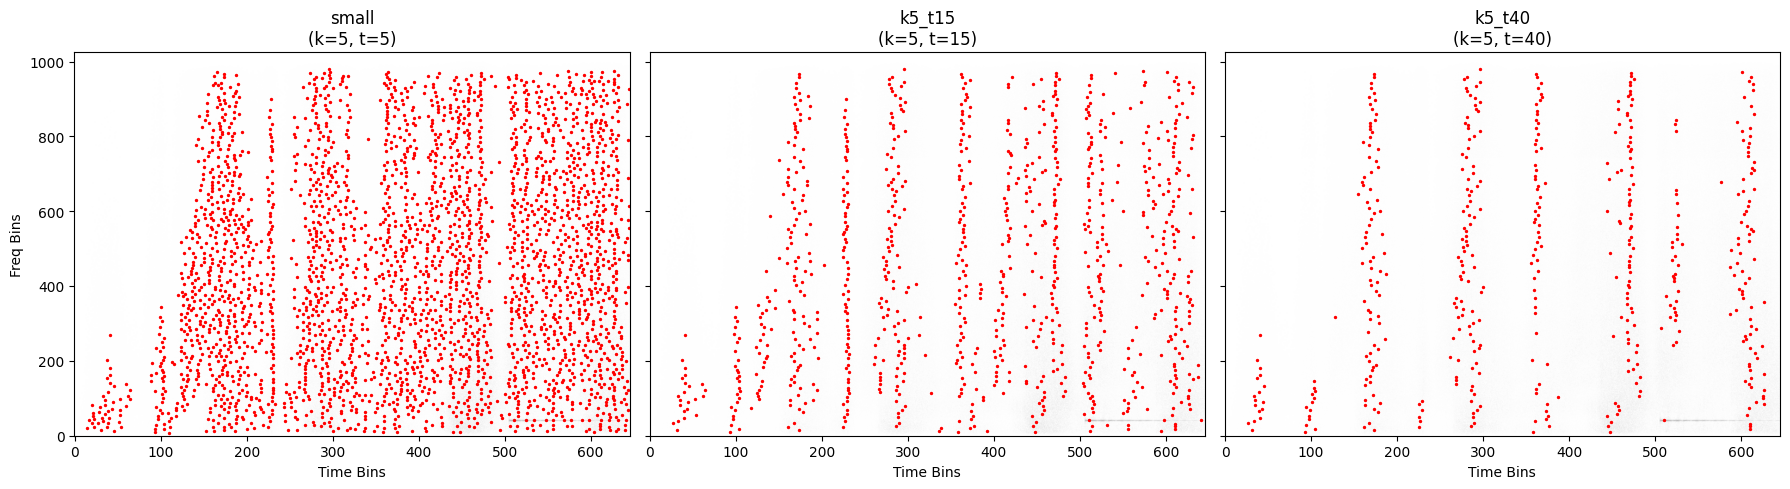

In [16]:
import matplotlib.pyplot as plt

def plot_exploration(filename, configs_to_show):
    y, sr = librosa.load("data/40/2240.mp3", duration=30, sr=22050)
    Y = np.abs(librosa.stft(y, n_fft=2048, hop_length=1024))
    Y_log = np.log(1 + 10 * Y)
    
    fig, axes = plt.subplots(1, len(configs_to_show), figsize=(18, 5), sharey=True)
    
    for ax, cfg in zip(axes, configs_to_show):
        peaks = get_peaks(Y, cfg['k'], cfg['t'])
        
        ax.imshow(Y_log, origin='lower', aspect='auto', cmap='gray_r', alpha=0.3)
        
        ax.scatter(peaks[:, 1], peaks[:, 0], s=2, c='red', marker='o')
        
        ax.set_title(f"{cfg['name']}\n(k={cfg['k']}, t={cfg['t']})")
        ax.set_xlabel('Time Bins')
    
    axes[0].set_ylabel('Freq Bins')
    plt.tight_layout()
    plt.show()

plot_exploration('1408740.mp3', CONFIGS[:3])

You can see that **small window size** captures many peaks and is very dense overall. Many details are captured but, this leads to high computation and potentially many false positives, because too much noise is interpreted as peaks. 
The **medium config** results in vertical lines, which typically represent the onsets. This is a promising configuration for querying. 
The **large config** results in a very sparse representation, where only the strongest peaks are caputred. Here the risk is high for short audio tracks or noisy tracks, that no matches are found, because of missing informations. 

Based on the visual analysis of these three configs, we made variations of the promising medium config to balance and optimize the parameters even more. With $\kappa=18$ (best_v2) we test a less granular frequency filter, in the hope to make the map even clearer. $\tau=20$ (best_v3), makes the time steps bigger and looks if this helps for a better identification of the peaks.

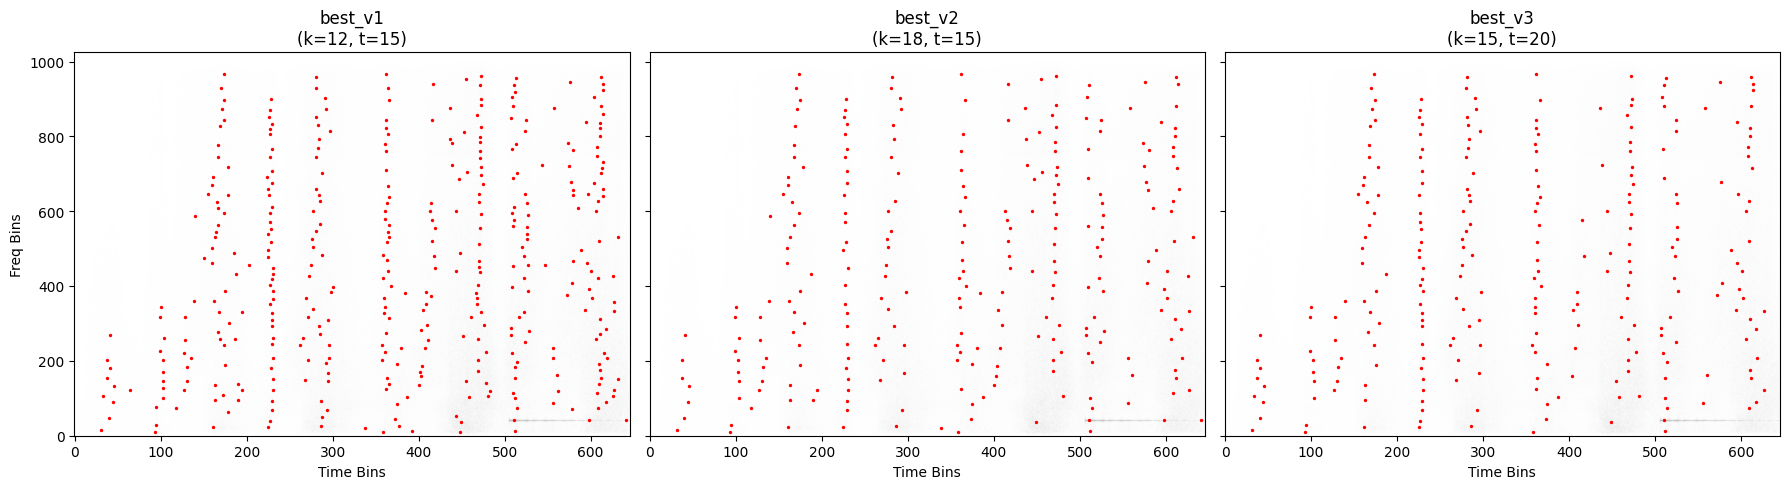

In [17]:
plot_exploration('1408740.mp3', CONFIGS[-3:])

best_v1 ($\kappa=12$): Testing a slightly higher frequency density. <br>
best_v2 ($\kappa=18$): Testing more frequency isolation for cleaner peaks. <br>
best_v3 ($\tau=20$): Testing a larger time context to focus on only the most significant temporal events.

## save in pickle file

In [20]:
with open('music_database_full.pkl', 'wb') as f:
    pickle.dump(database, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Caputred in database!")

Caputred in database!


All calculated maps for the 500+ tracks and 6 configurations were stored in a dictionary-based structure (Pickle format) to allow unambiguous mapping between files and representations.

In [21]:
print(f"load databsae: {"music_database_full.pkl"} ...")
with open("music_database_full.pkl", 'rb') as f:
    db = pickle.load(f)
    
configs = list(db.keys())
print(f"found configurations: {configs}")
    
for cfg in configs:
    num_songs = len(db[cfg])
    print(f" -> '{cfg}': {num_songs} tracks captured.")

load databsae: music_database_full.pkl ...
found configurations: ['small', 'k5_t15', 'k5_t40', 'k15_t5', 'medium', 'k15_t40', 'k40_t5', 'k40_t15', 'large', 'best_v1', 'best_v2', 'best_v3']
 -> 'small': 574 tracks captured.
 -> 'k5_t15': 574 tracks captured.
 -> 'k5_t40': 574 tracks captured.
 -> 'k15_t5': 574 tracks captured.
 -> 'medium': 574 tracks captured.
 -> 'k15_t40': 574 tracks captured.
 -> 'k40_t5': 574 tracks captured.
 -> 'k40_t15': 574 tracks captured.
 -> 'large': 574 tracks captured.
 -> 'best_v1': 574 tracks captured.
 -> 'best_v2': 574 tracks captured.
 -> 'best_v3': 574 tracks captured.
